<a href="https://colab.research.google.com/github/greyhound101/IEEE-CIS-Fraud/blob/master/simple_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "tapaskd123" # username from the json file
os.environ['KAGGLE_KEY'] = "aba8dc1f085221111d925003fe5a88ed" # key from the json file
!kaggle competitions download -c ieee-fraud-detection

train_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
n_fold=5
lr=0.0001

In [4]:
import pandas as pd
trn=pd.read_csv('/content/gdrive/My Drive/fraud/train.csv')
tst=pd.read_csv('/content/gdrive/My Drive/fraud/test.csv')

In [5]:
from tensorflow.keras.layers import *
import tensorflow as tf
import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf

In [6]:
from sklearn.preprocessing import LabelEncoder
import numpy as np


class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [7]:
from sklearn.preprocessing import LabelEncoder
cols=list(trn.select_dtypes(include=object))
for col in cols:
  le=LabelEncoderExt()
  le.fit(trn[col].astype(str))
  trn[col]=le.transform(trn[col].astype(str))
  tst[col] = tst[col].map(lambda s: '<unknown>' if s not in le.classes_ else s)
  tst[col]=le.transform(tst[col].astype(str))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


In [8]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from keras.layers import *
from keras.optimizers import *
from keras.models import *
from keras import backend as K
ss=StandardScaler()
frd=trn['isFraud']
ls=list(trn)
trn=ss.fit_transform(trn.drop(['isFraud'],1))
trn=pd.DataFrame(trn)

In [9]:
ls.remove('isFraud')
trn.columns=ls
trn['isFraud']=frd

ls=list(tst)
tst=ss.fit_transform(tst)
tst=pd.DataFrame(tst)
tst.columns=ls

In [10]:
tst.shape,trn.shape

((506691, 370), (590540, 371))

In [11]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
trn=reduce_mem_usage(trn)
tst=reduce_mem_usage(tst)

Memory usage of dataframe is 1671.53 MB
Memory usage after optimization is: 417.88 MB
Decreased by 75.0%
Memory usage of dataframe is 1430.33 MB
Memory usage after optimization is: 357.58 MB
Decreased by 75.0%


In [12]:
trn_n=pd.read_csv('train_transaction.csv.zip')
tst_n=pd.read_csv('test_transaction.csv.zip')
trn_ls=list(trn_n)
tst_ls=list(tst_n)
for col in trn:
  if col in trn_ls:
    trn[col+'_isna']=trn_n[col].isna().astype('uint8')
for col in tst:
  if col in tst_ls:
    tst[col+'_isna']=tst_n[col].isna().astype('uint8')
import gc
del([trn_n,tst_n])
gc.collect()

0

In [14]:
trn=trn.drop(['isFraud_isna'],1)
trn.shape,tst.shape

((590540, 594), (506691, 593))

In [17]:

from keras.utils import *
def load_model():
  K.clear_session()
  inp=Input((593,))
  x=Dense(256,activation='relu')(inp)
  x=Dropout(0.3)(x)
  x=BatchNormalization()(x)
  x=Dense(256,activation='relu')(x)
  x=Dropout(0.3)(x)
  x=BatchNormalization()(x)
  x=Dense(256,activation='relu')(x)
  x=Dropout(0.3)(x)
  x=BatchNormalization()(x)
  x=Dense(1,activation='sigmoid')(x)
  mod=Model(inputs=inp,outputs=x)
  return mod
kf = KFold(n_splits=n_fold)
for en,(train_index, test_index) in enumerate(kf.split(trn)):
  train=trn.loc[train_index].reset_index(drop=True)
  test=trn.loc[test_index].reset_index(drop=True)
  mod=load_model()
  mod.compile(optimizer=Adam(0.0001,decay=1e-5),loss='binary_crossentropy',metrics='accuracy')
  es=EarlyStopping(monitor='val_loss',min_delta=0.0001,mode='min',restore_best_weights=True,patience=5)
  mod.fit(train.drop(['isFraud'],1),train['isFraud'],validation_data=(test.drop(['isFraud'],1),test['isFraud']),batch_size=2048,epochs=1000,callbacks=[es])
  del([train,test])
  gc.collect()
  if en==0:
    pre=mod.predict(tst)/n_fold
  else:
    pre+=mod.predict(tst)/n_fold

Epoch 1/1000
231/231 [==============================] - 2s 10ms/step - loss: 0.6715 - accuracy: 0.6614 - val_loss: 0.5512 - val_accuracy: 0.9158
Epoch 2/1000
231/231 [==============================] - 2s 7ms/step - loss: 0.4646 - accuracy: 0.8856 - val_loss: 0.3909 - val_accuracy: 0.9593
Epoch 3/1000
231/231 [==============================] - 2s 7ms/step - loss: 0.3091 - accuracy: 0.9495 - val_loss: 0.2806 - val_accuracy: 0.9669
Epoch 4/1000
231/231 [==============================] - 2s 7ms/step - loss: 0.2126 - accuracy: 0.9613 - val_loss: 0.2499 - val_accuracy: 0.9681
Epoch 5/1000
231/231 [==============================] - 2s 7ms/step - loss: 0.1669 - accuracy: 0.9645 - val_loss: 0.2565 - val_accuracy: 0.9685
Epoch 6/1000
231/231 [==============================] - 2s 7ms/step - loss: 0.1453 - accuracy: 0.9655 - val_loss: 0.2458 - val_accuracy: 0.9692
Epoch 7/1000
231/231 [==============================] - 2s 7ms/step - loss: 0.1335 - accuracy: 0.9662 - val_loss: 0.2804 - val_accuracy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


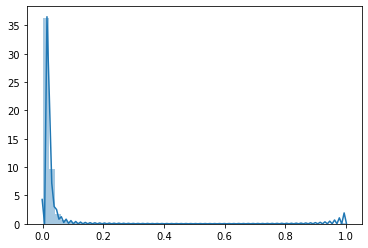

In [19]:
import seaborn as sns
sns.distplot(pre)

In [22]:
np.save('predictions.npy',pre)

In [24]:
lbl=pd.read_csv('sample_submission.csv.zip')
lbl.head()

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


In [25]:
lbl['isFraud']=pre.ravel()

In [27]:
lbl=lbl.set_index('TransactionID')
lbl.to_csv('sub.csv')